In [3]:
! python -m pip install -q towhee opencv-python pillow

/usr/bin/python: No module named pip


In [4]:


! curl -L https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip -O
! unzip -q -o reverse_image_search.zip



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  10.1M      0  0:00:11  0:00:11 --:--:-- 11.1M


In [1]:
import csv
from glob import glob
from pathlib import Path
from statistics import mean

from towhee import pipe, ops, DataCollection
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility


# Towhee parameters
MODEL = 'resnet50'
DEVICE = None # if None, use default device (cuda is enabled if available)

# Milvus parameters
HOST = '127.0.0.1'
PORT = '19530'
TOPK = 13
DIM = 2048 # dimension of embedding extracted by MODEL
COLLECTION_NAME = 'reverse_image_search'
INDEX_TYPE = 'IVF_FLAT'
METRIC_TYPE = 'L2'

# path to csv (column_1 indicates image path) OR a pattern of image paths
INSERT_SRC = 'reverse_image_search.csv'
QUERY_SRC = './test/*/*.JPEG'

In [2]:
# Load image path
def load_image(x):
    if x.endswith('csv'):
        with open(x) as f:
            reader = csv.reader(f)
            next(reader)
            for item in reader:
                yield item[1]
    else:
        for item in glob(x):
            yield item
            
# Embedding pipeline
p_embed = (
    pipe.input('src')
        .flat_map('src', 'img_path', load_image)
        .map('img_path', 'img', ops.image_decode())
        .map('img', 'vec', ops.image_embedding.timm(model_name=MODEL, device=DEVICE))
)

img_path,img,vec
./test/goldfish/n01443537_3883.JPEG,,"[0.0, 0.0, 0.0, ...] shape=(2048,)"

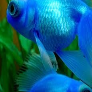

In [3]:
# Display embedding result, no need for implementation
p_display = p_embed.output('img_path', 'img', 'vec')
DataCollection(p_display('./test/goldfish/*.JPEG')).show()

In [4]:
# Create milvus collection (delete first if exists)
def create_milvus_collection(collection_name, dim):
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
        FieldSchema(name='path', dtype=DataType.VARCHAR, description='path to image', max_length=500, 
                    is_primary=True, auto_id=False),
        FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, description='image embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='reverse image search')
    collection = Collection(name=collection_name, schema=schema)

    index_params = {
        'metric_type': METRIC_TYPE,
        'index_type': INDEX_TYPE,
        'params': {"nlist": 2048}
    }
    collection.create_index(field_name='embedding', index_params=index_params)
    return collection

In [5]:
# Connect to Milvus service
connections.connect(host=HOST, port=PORT)

# Create collection
collection = create_milvus_collection(COLLECTION_NAME, DIM)
print(f'A new collection created: {COLLECTION_NAME}')

A new collection created: reverse_image_search


In [6]:
# Insert pipeline
p_insert = (
        p_embed.map(('img_path', 'vec'), 'mr', ops.ann_insert.milvus_client(
                    host=HOST,
                    port=PORT,
                    collection_name=COLLECTION_NAME
                    ))
          .output('mr')
)

In [7]:
# Insert data
p_insert(INSERT_SRC)

# Check collection
print('Number of data inserted:', collection.num_entities)

Number of data inserted: 0


In [8]:
# Search pipeline
p_search_pre = (
        p_embed.map('vec', ('search_res'), ops.ann_search.milvus_client(
                    host=HOST, port=PORT, limit=TOPK,
                    collection_name=COLLECTION_NAME))
               .map('search_res', 'pred', lambda x: [str(Path(y[0]).resolve()) for y in x])
#                .output('img_path', 'pred')
)
p_search = p_search_pre.output('img_path', 'pred')

In [10]:


# Search for example query image(s)
collection.load()
dc = p_search('test/lion/*.JPEG')

# Display search results with image paths
DataCollection(dc).show()



img_path,pred
test/lion/n02129165_13728.JPEG,/home/kpamuk/milvus_ws/reverse_image_search/train/lion/n02129165_19310.JPEG /home/kpamuk/milvus_ws/reverse_image_search/train/lion/n02129165_19953.JPEG /home/kpamuk/milvus_ws/reverse_image_search/train/lion/n02129165_12949.JPEG /home/kpamuk/milvus_ws/reverse_image_search/train/lion/n02129165_17028.JPEG /home/kpamuk/milvus_ws/reverse_image_search/train/lion/n02129165_16.JPEG /home/kpamuk/milvus_ws/reverse_image_search/train/lion/n02129165_5845.JPEG /home/kpamuk/milvus_ws/reverse_image_search/train/lion/n02129165_1142.JPEG /home/kpamuk/milvus_ws/reverse_image_search/train/lion/n02129165_5362.JPEG /home/kpamuk/milvus_ws/reverse_image_search/train/tiger_cat/n02123159_1389.JPEG /home/kpamuk/milvus_ws/reverse_image_search/train/tiger_cat/n02123159_6208.JPEG /home/kpamuk/milvus_ws/reverse_image_search/train/kit_fox/n02119789_2736.JPEG /home/kpamuk/milvus_ws/reverse_image_search/train/American_egret/n02009912_8563.JPEG /home/kpamuk/milvus_ws/reverse_image_search/train/white_stork/n02002556_6322.JPEG


img,pred_images
,

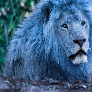
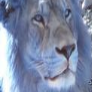
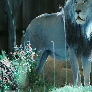
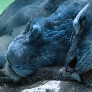
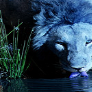
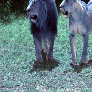
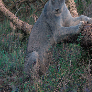
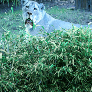
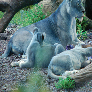
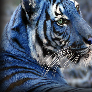
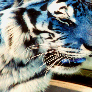
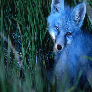
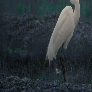
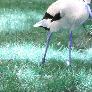

In [13]:
# Display search results with images, no need for implementation

import cv2
from towhee.types.image import Image

def read_images(img_paths):
    imgs = []
    for p in img_paths:
        imgs.append(Image(cv2.imread(p), 'BGR'))
    return imgs

p_search_img = (
    p_search_pre.map('pred', 'pred_images', read_images)
                .output('img', 'pred_images')
)
DataCollection(p_search_img('test/lion/*.JPEG')).show()